In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pickle
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
import matplotlib.pyplot as plt

In [4]:
from libraries import helper_functions as hp

In [5]:
assert torch.cuda.is_available()

In [6]:
assert torch.backends.cudnn.enabled

# Settings

In [7]:
path = "../data/"
train_dir = "train-jpg"
test_dir = 'test-merged'
csv = f'{path}train_v2.csv'
ext = '.jpg'

In [8]:
load_model_from_disk = True

In [9]:
no_validation = False

In [10]:
val_idxs = None if no_validation else hp.val_idxs_from_csv(csv, load_from_disk=load_model_from_disk)

Loaded 8095 indexes from file <_io.BufferedReader name='val_idxs.pkl'>.


In [11]:
architecture = resnext101 # = resnext101_32

In [12]:
max_zoom = 1.05

## Low Resolution

In [13]:
img_sz_low = 128
batch_sz_low = 50

In [13]:
img_sz_low = 64
batch_sz_low = 120

## High Resolution

In [14]:
img_sz_high= 224
batch_sz_high = 205

# Pretrain with low resolution

In [15]:
tfms_low = tfms_from_model(architecture, img_sz_low, transforms_top_down, max_zoom)

In [16]:
data_low = ImageClassifierData.from_csv(path, train_dir, csv, batch_sz_low, tfms_low, val_idxs, ext, test_dir)

In [17]:
learn = ConvLearner.pretrained(architecture, data_low, precompute=False)

## Train last layer

In [18]:
learn.lr_find()

epoch      trn_loss   val_loss   <lambda>                    
    0      0.264188   0.731924   0.927399  



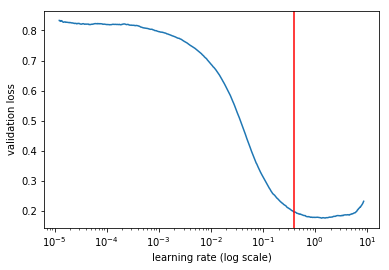

In [21]:
lr_low_last = 4e-1
learn.sched.plot()
plt.axvline(x=lr_low_last, color="red")

In [22]:
learn.fit(lr_low_last, 1)

epoch      trn_loss   val_loss   <lambda>                    
    0      0.127889   0.114397   0.955506  



[array([0.1144]), 0.9555060983872244]

In [23]:
low_lastlayer = 'low_lastlayer_128' + ('_all' if no_validation else ''); low_lastlayer

'low_lastlayer_128'

In [24]:
learn.save(low_lastlayer)

## Train all layers

In [75]:
learn.load(low_lastlayer)

In [25]:
learn.unfreeze()

In [26]:
torch.cuda.empty_cache()

In [27]:
learn.lr_find()

  0%|          | 0/663 [00:00<?, ?it/s]


RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCStorage.cu:58

In [27]:
# 2359 mb bei batch_size=5

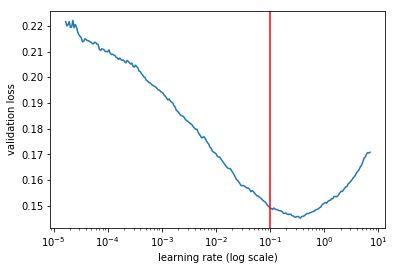

In [28]:
lr_low_all=1e-1
learn.sched.plot()
plt.axvline(x=lr_low_all, color="red")

In [29]:
lr=np.array([lr_low_all/100,lr_low_all/10,lr_low_all])

In [30]:
learn.fit(lr, 4, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   <lambda>                    
    0      0.123459   0.112203   0.956538  
    1      0.112644   0.103393   0.959808                    
    2      0.108986   0.101838   0.960535                    
    3      0.106106   0.099356   0.961138                    
    4      0.10059    0.097076   0.962003                    
    5      0.098271   0.095947   0.962373                     
    6      0.09743    0.096123   0.962555                     
    7      0.097223   0.095044   0.962562                     
    8      0.095876   0.093994   0.963478                     
    9      0.091382   0.093391   0.963507                     
    10     0.091806   0.094756   0.962751                     
    11     0.090579   0.093999   0.963565                     
    12     0.088328   0.093032   0.963732                     
    13     0.086394   0.092901   0.963689                     
    14     0.086479   0.093201   0.963594                     



[array([0.0932]), 0.9635940824415008]

In [31]:
# image_size 64, batch_size 60: 2686mb (2448)

In [32]:
# batch_size 5: 2404mb (2299mb anaconda)
# batch_size 10: 3324mb (3086mb anaconda)
# batch_size 13: 3899mb (3571mb anaconda)

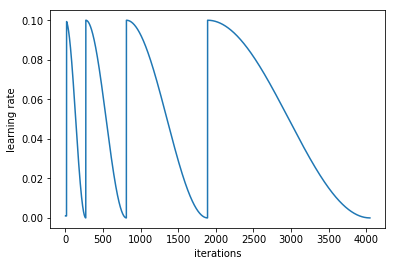

In [33]:
learn.sched.plot_lr()

In [34]:
all64 = 'low_all_all' if no_validation else 'low_all'

In [35]:
learn.save(all64)

# Larger Images

In [36]:
learn.load(all64)

In [37]:
tfms_high = tfms_from_model(architecture, img_sz_high, transforms_top_down, max_zoom)

In [38]:
data_high = ImageClassifierData.from_csv(path, train_dir, csv, batch_sz_high, tfms_high, val_idxs, ext, test_dir)

In [39]:
learn.set_data(data_high)

In [40]:
learn.freeze()

In [41]:
learn.lr_find()

epoch      trn_loss   val_loss   <lambda>                    
    0      0.132738   0.118022   0.955644  



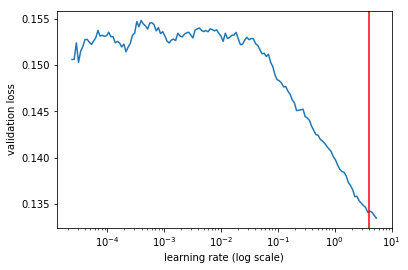

In [42]:
learning_rate2=4
learn.sched.plot()
plt.axvline(x=learning_rate2, color="red")

In [44]:
learn.fit(learning_rate2, 4, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   <lambda>                    
    0      0.111228   0.101974   0.960746  
    1      0.110265   0.099952   0.961414                    
    2      0.102077   0.096324   0.962649                    
    3      0.107579   0.099925   0.961283                    
    4      0.104036   0.096054   0.96302                     
    5      0.099303   0.094245   0.963478                     
    6      0.097029   0.09405    0.963572                     
    7      0.10383    0.09701    0.962257                    
    8      0.103775   0.097493   0.962097                    
    9      0.09991    0.096763   0.962497                     
    10     0.099139   0.094376   0.963398                     
    11     0.097389   0.093201   0.964125                     
    12     0.094028   0.092322   0.964204                     
    13     0.093683   0.092035   0.96435                      
    14     0.093497   0.091738   0.96443                      



[array([0.09174]), 0.9644297509741239]

In [45]:
last224 = 'high_last_all' if no_validation else 'high_last'

In [46]:
learn.save(last224)

# Find proper threshold

In [47]:
val_probs, val_true = learn.TTA()

In [48]:
val_prob = np.average(val_probs, axis=0)

In [49]:
val_prob.shape

(8095, 17)

In [50]:
th = hp.get_threshold(val_true, val_prob);th #0.18

/home/donare/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


0.18999999999999995

In [63]:
hp.f2(val_true, val_prob>0.19)

0.9244703928046534

# Submission

In [53]:
probs_test, true_test = learn.TTA(is_test=True)

In [54]:
probs_test = np.average(probs_test, axis=0)

In [55]:
submission = hp.create_submission(probs_test, data_low, th)

In [56]:
submission_file = 'submission_224_all'

In [57]:
submission.to_csv(submission_file, index=False)

In [58]:
!kaggle competitions submit -c planet-understanding-the-amazon-from-space -f {submission_file} -m "Test Kaggle Submission Process form Jupyter"

Successfully submitted to Planet: Understanding the Amazon from Space